# utils & framework

In [1]:
from collections.abc import Iterable
from os import O_TEXT

import scipy.constants
import sympy
from IPython.core.display import Markdown
from sympy import *
from sympy.vector import *

ASSUM = sympy.Q

tag_id = 0
conditions = {}
values = {}
formulas_names = {}
restore_stack = []


def reset():
    global tag_id, conditions, values, formulas_names
    if restore_stack:
        state = restore_stack[-1]
        tag_id = state['tag_id']
        conditions = state['conditions'].copy()
        values = state['values'].copy()
        formulas_names = state['formulas_names'].copy()


def push_state():
    global restore_stack
    restore_stack.append({
        'tag_id': tag_id,
        'conditions': conditions.copy(),
        'values': values.copy(),
        'formulas_names': formulas_names.copy()
    })


def pop_state():
    global restore_stack
    return restore_stack.pop()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    condition = spf(condition)
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression, mask=None):
    while True:
        left = False
        items = values.items() if mask is None else filter(lambda item: item[0] in mask, values.items())
        for (key, value) in items:
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="$", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$", f: bool = False):
    symbol = expression
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(Eq(symbol, expression, evaluate=false), message, tag="answer")


def beautiful_inlined(expression, tag=None):
    expression = spf(expression)
    beautiful_print(expression, "inlined:$", tag)


def beautiful_peek(expression, message="$", tag=None):
    symbol= expression(False) if callable(expression) else expression
    value = spf(expression(True) if callable(expression) else expression)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    cond = map(lambda i: substitute_values(i), cond)
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, expression(True) if callable(expression) else expression)
    return symbol


def beautiful_compute_at(symbol, expression, subs: dict, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression.subs(subs), evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, substitute_values(expression).subs(subs))
    return symbol


def beautiful_formula(symbol: str, expression: object, message: object = "$", ):
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    expression = expression.doit()
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))


def md(msg):
    display(Markdown(msg))


def spt():
    md("-----------------")


def beautiful_vector(xi=0, yj=0, zk=0):
    xi = Symbol(xi) if isinstance(xi, str) else xi
    yj = Symbol(yj) if isinstance(yj, str) else yj
    zk = Symbol(zk) if isinstance(zk, str) else zk
    return xi * coord.i + yj * coord.j + zk * coord.k


def beautiful_branch_at(expression, index):
    expression = spf(expression)
    branch, cond = expression.args[index]
    return branch


def refine_piecewise(pw_expr, assume):
    pw_expr = spf(pw_expr)

    for expr_val, cond in pw_expr.args:
        if ask(cond, assume):
            return refine(expr_val, assume)

    # If no branch can be definitively chosen, refine each branch
    refined_args = [(refine(expr_val, assume), cond)
                    for expr_val, cond in pw_expr.args]
    return Piecewise(*refined_args)


coord = CoordSys3D('')

## Common

In [2]:
epsilon_0 = symbols('epsilon_0', positive=True)
k = 1 / (4 * pi * epsilon_0)
charge = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * charge * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon_0), "by Gauss's law:$")


def fn_potential(q, r):
    return k * q / r


P = beautiful_formula('\\varphi', fn_potential(charge, pos.magnitude()), 'electric potential:$')


def save_common_consts():
    save_as_variable(epsilon_0, scipy.constants.epsilon_0)
    save_as_variable(pi, scipy.constants.pi)


push_state()

by Coulomb's law:$$E=\left(\frac{\mathbf{{x}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}\tag{0}$$

by Gauss's law:$$\phi_{e} = \frac{Q_{sum}}{\epsilon_{0}}\tag{1}$$

electric potential:$$\varphi=\frac{q}{4 \pi \epsilon_{0} \sqrt{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}}}\tag{2}$$

# 3.10
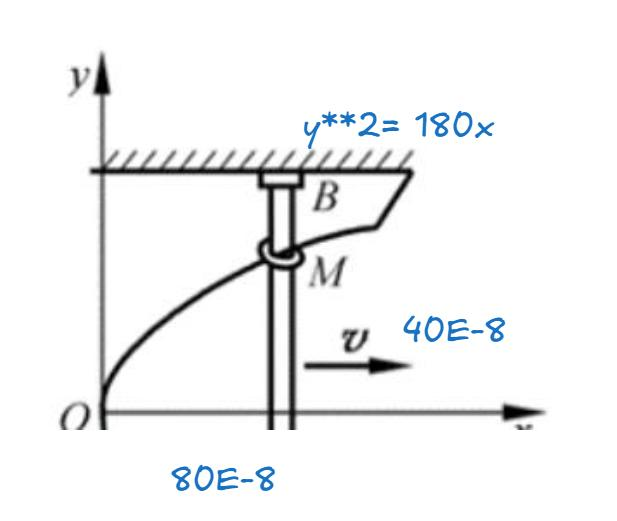

In [3]:
reset()


def t310():
    t = Symbol('t')
    v = Symbol('v')
    save_as_variable(v, 40)
    x = beautiful_compute(Function('x')(t), t * v)
    y = beautiful_compute(Function('y')(t), sqrt(180 * x))

    save_as_variable(t, 2)
    beautiful_answer(diff(x, t))
    beautiful_answer(diff(x, t, 2))
    beautiful_answer(diff(y, t))
    beautiful_answer(diff(y, t, 2))

    md("------------------")

    beautiful_answer(diff(y, t))
    beautiful_answer(diff(y, t, 2))


t310()

$$x{\left(t \right)} = t v$$

$$y{\left(t \right)} = 6 \sqrt{5} \sqrt{x{\left(t \right)}}$$

$$\frac{d}{d t} x{\left(t \right)} = 40\tag{answer}$$

$$\frac{d^{2}}{d t^{2}} x{\left(t \right)} = 0\tag{answer}$$

$$\frac{d}{d t} y{\left(t \right)} = 30\tag{answer}$$

$$\frac{d^{2}}{d t^{2}} y{\left(t \right)} = - \frac{15}{2}\tag{answer}$$

------------------

$$\frac{d}{d t} y{\left(t \right)} = 30\tag{answer}$$

$$\frac{d^{2}}{d t^{2}} y{\left(t \right)} = - \frac{15}{2}\tag{answer}$$

# 3.11
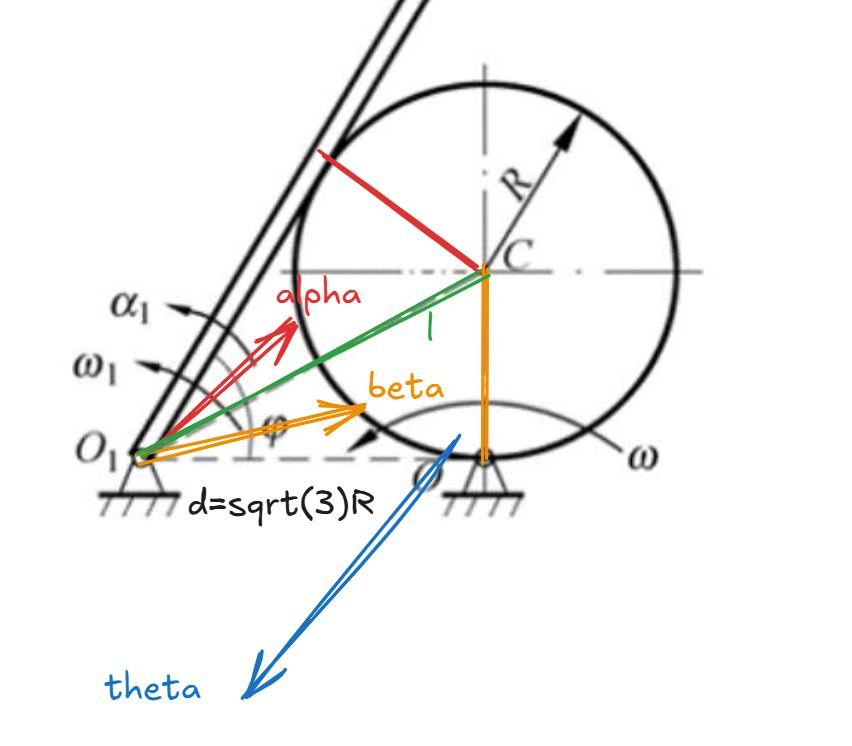

In [4]:
reset()


def t311():
    t = Symbol('t', positive=True)
    omega = Symbol('omega', positive=True)
    theta = beautiful_compute(Function('theta')(t), pi / 2 - omega * t)
    R = Symbol('R', positive=True)
    d = beautiful_compute('d', sqrt(3) * R)
    l = beautiful_compute('l', sqrt(R ** 2 + d ** 2 - 2 * d * R * cos(theta)))
    beautiful_peek(l)
    alpha = beautiful_compute(Function('alpha')(t), asin(R / l))
    bbb = beautiful_compute(Function('beta')(t), asin(R/l * sin(theta)))
    # b1 = beautiful_condition(Eq(sin(bbb) / R, sin(theta) / l))
    # beautiful_solve(b1, bbb)
    phi = beautiful_compute(Function('phi')(t), alpha + bbb)
    beautiful_peek(phi)

    beautiful_peek(diff(phi, t))
    beautiful_peek(diff(phi, t, 2))

    save_as_variable(t, 0)
    beautiful_answer(diff(phi, t))
    beautiful_answer(diff(phi, t, 2))


t311()

$$\theta{\left(t \right)} = - \omega t + \frac{\pi}{2}$$

$$d = \sqrt{3} R$$

$$l = \sqrt{R^{2} - 2 R d \cos{\left(\theta{\left(t \right)} \right)} + d^{2}}$$

$$l = R \sqrt{- 2 \sqrt{3} \sin{\left(\omega t \right)} + 4}$$

$$\alpha{\left(t \right)} = \operatorname{asin}{\left(\frac{R}{l} \right)}$$

$$\beta{\left(t \right)} = \operatorname{asin}{\left(\frac{R \sin{\left(\theta{\left(t \right)} \right)}}{l} \right)}$$

$$\phi{\left(t \right)} = \alpha{\left(t \right)} + \beta{\left(t \right)}$$

$$\phi{\left(t \right)} = \operatorname{asin}{\left(\frac{\sqrt{2}}{2 \sqrt{- \sqrt{3} \sin{\left(\omega t \right)} + 2}} \right)} + \operatorname{asin}{\left(\frac{\sqrt{2} \cos{\left(\omega t \right)}}{2 \sqrt{- \sqrt{3} \sin{\left(\omega t \right)} + 2}} \right)}$$

$$\frac{d}{d t} \phi{\left(t \right)} = \frac{\omega \left(\sqrt{2} \sqrt{\frac{2 \sqrt{3} \sin{\left(\omega t \right)} - 3}{\sqrt{3} \sin{\left(\omega t \right)} - 2}} \left(\sqrt{6} \sin^{2}{\left(\omega t \right)} - 4 \sqrt{2} \sin{\left(\omega t \right)} + \sqrt{6}\right) + 2 \sqrt{3} \sqrt{\frac{2 \sqrt{3} \sin{\left(\omega t \right)} + \cos^{2}{\left(\omega t \right)} - 4}{\sqrt{3} \sin{\left(\omega t \right)} - 2}} \cos{\left(\omega t \right)}\right)}{4 \sqrt{\frac{2 \sqrt{3} \sin{\left(\omega t \right)} - 3}{\sqrt{3} \sin{\left(\omega t \right)} - 2}} \sqrt{\frac{2 \sqrt{3} \sin{\left(\omega t \right)} + \cos^{2}{\left(\omega t \right)} - 4}{\sqrt{3} \sin{\left(\omega t \right)} - 2}} \left(- \sqrt{3} \sin{\left(\omega t \right)} + 2\right)^{\frac{3}{2}}}$$

$$\frac{d^{2}}{d t^{2}} \phi{\left(t \right)} = \frac{\sqrt{2} \omega^{2} \left(- \frac{\left(\frac{2 \sqrt{3} \sin{\left(\omega t \right)} - 3}{\sqrt{3} \sin{\left(\omega t \right)} - 2}\right)^{\frac{5}{2}} \sqrt{\frac{2 \sqrt{3} \sin{\left(\omega t \right)} + \cos^{2}{\left(\omega t \right)} - 4}{\sqrt{3} \sin{\left(\omega t \right)} - 2}} \left(\sqrt{3} \sin{\left(\omega t \right)} - 2\right)^{2} \left(3 \sqrt{2} \sin^{4}{\left(\omega t \right)} - 11 \sqrt{6} \sin^{3}{\left(\omega t \right)} + 45 \sqrt{2} \sin^{2}{\left(\omega t \right)} - 27 \sqrt{6} \sin{\left(\omega t \right)} + 18 \sqrt{2}\right) \cos{\left(\omega t \right)}}{4} + \frac{\sqrt{2} \left(- 6 \sqrt{3} \sin{\left(\omega t \right)} + 9\right) \left(2 \sqrt{3} \sin{\left(\omega t \right)} + \cos^{2}{\left(\omega t \right)} - 4\right)^{2} \cos^{2}{\left(\omega t \right)}}{8} + \frac{\left(2 \sqrt{3} \sin{\left(\omega t \right)} - 3\right)^{2} \left(- 3 \sqrt{2} \sin^{2}{\left(\omega t \right)} - 4 \sqrt{6} \sin{\left(\omega t \right)} + 9 \sqrt{2}\right) \left(2 \sqrt{3} \sin{\left(\omega t \right)} + \cos^{2}{\left(\omega t \right)} - 4\right)^{2}}{8}\right)}{\left(\frac{2 \sqrt{3} \sin{\left(\omega t \right)} - 3}{\sqrt{3} \sin{\left(\omega t \right)} - 2}\right)^{\frac{5}{2}} \left(- \sqrt{3} \sin{\left(\omega t \right)} + 2\right)^{\frac{9}{2}} \left(2 \sqrt{3} \sin{\left(\omega t \right)} + \cos^{2}{\left(\omega t \right)} - 4\right)^{2}}$$

$$\frac{d}{d t} \phi{\left(t \right)} = \frac{\omega}{2}\tag{answer}$$

$$\frac{d^{2}}{d t^{2}} \phi{\left(t \right)} = \frac{\sqrt{3} \omega^{2}}{12}\tag{answer}$$

# 3.17
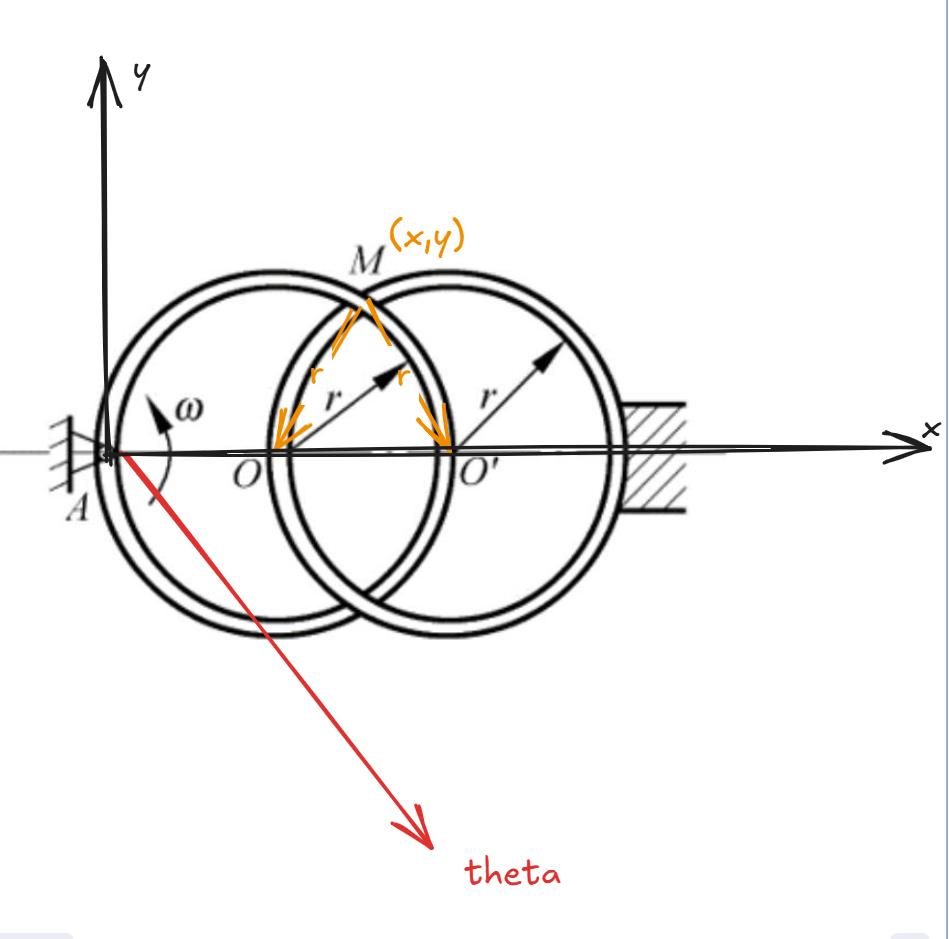

In [5]:
reset()


def t317():
    t = Symbol('t', positive=True)
    omega = Symbol('omega', positive=True)
    theta = beautiful_compute(Function('theta')(t), omega * t)
    r = symbols('r', positive=True)
    O_x = beautiful_compute('O_x', cos(theta) * r)
    O_y = beautiful_compute('O_y', sin(theta) * r)

    O_x2 = beautiful_compute('O_{x2}', 2 * r)
    O_y2 = beautiful_compute('O_{y2}', 0)

    x = Function('x', positive=True)(t)
    y = Function('y', positive=True)(t)

    def disq(x1, x2, x3, x4):
        return (x1 - x2) ** 2 + (x3 - x4) ** 2

    c1 = beautiful_condition(Eq(r ** 2, disq(x, O_x, y, O_y)))
    c2 = beautiful_condition(
        Eq(r ** 2, disq(x, O_x2, y, O_y2)),
    )
    beautiful_solve([c1, c2], [x, y])
    beautiful_peek(diff(x, t))
    beautiful_peek(diff(y, t))

    beautiful_peek(diff(x, t, 2))
    beautiful_peek(diff(y, t, 2))

    save_as_variable(t, 0)
    beautiful_answer(sqrt(diff(x, t) ** 2 + diff(y, t) ** 2), "size of:$")
    beautiful_answer(sqrt(diff(x, t, 2) ** 2 + diff(y, t, 2) ** 2), "size of:$")


t317()

$$\theta{\left(t \right)} = \omega t$$

$$O_{x} = r \cos{\left(\theta{\left(t \right)} \right)}$$

$$O_{y} = r \sin{\left(\theta{\left(t \right)} \right)}$$

$$O_{x2} = 2 r$$

$$O_{y2} = 0$$

$$r^{2} = \left(- O_{x} + x{\left(t \right)}\right)^{2} + \left(- O_{y} + y{\left(t \right)}\right)^{2}\tag{3}$$

$$r^{2} = \left(- O_{x2} + x{\left(t \right)}\right)^{2} + \left(- O_{y2} + y{\left(t \right)}\right)^{2}\tag{4}$$

$\left ( 3 \right ) ,\left ( 4 \right )  \Longrightarrow$

$$x{\left(t \right)} = \frac{r \left(- \sqrt{- 16 \sin^{4}{\left(\omega t \right)} + 197 \sin^{2}{\left(\omega t \right)} + 182 \cos{\left(\omega t \right)} + 22 \cos{\left(3 \omega t \right)} - 201} \sin{\left(\omega t \right)} - 5 \sin^{2}{\left(\omega t \right)} + 13 \cos{\left(\omega t \right)} - \cos{\left(3 \omega t \right)} - 15\right)}{2 \left(13 \cos{\left(\omega t \right)} - 2 \cos{\left(2 \omega t \right)} - 12\right)}$$

$$y{\left(t \right)} = \frac{r \left(2 \left(4 \cos{\left(\omega t \right)} - 5\right) \sin{\left(\omega t \right)} - \sqrt{728 \cos{\left(\omega t \right)} - 362 \cos{\left(2 \omega t \right)} + 88 \cos{\left(3 \omega t \right)} - 8 \cos{\left(4 \omega t \right)} - 434}\right)}{4 \left(4 \cos{\left(\omega t \right)} - 5\right)}$$

$$\frac{d}{d t} x{\left(t \right)} = \frac{\omega r \left(\left(2 \left(\sqrt{- 16 \sin^{4}{\left(\omega t \right)} + 197 \sin^{2}{\left(\omega t \right)} + 182 \cos{\left(\omega t \right)} + 22 \cos{\left(3 \omega t \right)} - 201} \cos{\left(\omega t \right)} + 13 \sin{\left(\omega t \right)} + 5 \sin{\left(2 \omega t \right)} - 3 \sin{\left(3 \omega t \right)}\right) \sqrt{- 16 \sin^{4}{\left(\omega t \right)} + 197 \sin^{2}{\left(\omega t \right)} + 182 \cos{\left(\omega t \right)} + 22 \cos{\left(3 \omega t \right)} - 201} - \left(182 \sin{\left(\omega t \right)} - 181 \sin{\left(2 \omega t \right)} + 66 \sin{\left(3 \omega t \right)} - 8 \sin{\left(4 \omega t \right)}\right) \sin{\left(\omega t \right)}\right) \left(- 13 \cos{\left(\omega t \right)} + 2 \cos{\left(2 \omega t \right)} + 12\right) - 2 \left(13 \sin{\left(\omega t \right)} - 4 \sin{\left(2 \omega t \right)}\right) \left(\sqrt{- 16 \sin^{4}{\left(\omega t \right)} + 197 \sin^{2}{\left(\omega t \right)} + 182 \cos{\left(\omega t \right)} + 22 \cos{\left(3 \omega t \right)} - 201} \sin{\left(\omega t \right)} + 5 \sin^{2}{\left(\omega t \right)} - 13 \cos{\left(\omega t \right)} + \cos{\left(3 \omega t \right)} + 15\right) \sqrt{- 16 \sin^{4}{\left(\omega t \right)} + 197 \sin^{2}{\left(\omega t \right)} + 182 \cos{\left(\omega t \right)} + 22 \cos{\left(3 \omega t \right)} - 201}\right)}{4 \left(- 13 \cos{\left(\omega t \right)} + 2 \cos{\left(2 \omega t \right)} + 12\right)^{2} \sqrt{- 16 \sin^{4}{\left(\omega t \right)} + 197 \sin^{2}{\left(\omega t \right)} + 182 \cos{\left(\omega t \right)} + 22 \cos{\left(3 \omega t \right)} - 201}}$$

$$\frac{d}{d t} y{\left(t \right)} = \frac{\sqrt{2} \omega r \left(2 \left(2 \left(4 \cos{\left(\omega t \right)} - 5\right) \sin{\left(\omega t \right)} - \sqrt{728 \cos{\left(\omega t \right)} - 362 \cos{\left(2 \omega t \right)} + 88 \cos{\left(3 \omega t \right)} - 8 \cos{\left(4 \omega t \right)} - 434}\right) \sqrt{728 \cos{\left(\omega t \right)} - 362 \cos{\left(2 \omega t \right)} + 88 \cos{\left(3 \omega t \right)} - 8 \cos{\left(4 \omega t \right)} - 434} \sin{\left(\omega t \right)} - \left(4 \cos{\left(\omega t \right)} - 5\right) \left(\left(5 \cos{\left(\omega t \right)} - 4 \cos{\left(2 \omega t \right)}\right) \sqrt{728 \cos{\left(\omega t \right)} - 362 \cos{\left(2 \omega t \right)} + 88 \cos{\left(3 \omega t \right)} - 8 \cos{\left(4 \omega t \right)} - 434} - 182 \sin{\left(\omega t \right)} + 181 \sin{\left(2 \omega t \right)} - 66 \sin{\left(3 \omega t \right)} + 8 \sin{\left(4 \omega t \right)}\right)\right)}{4 \left(4 \cos{\left(\omega t \right)} - 5\right)^{2} \sqrt{364 \cos{\left(\omega t \right)} - 181 \cos{\left(2 \omega t \right)} + 44 \cos{\left(3 \omega t \right)} - 4 \cos{\left(4 \omega t \right)} - 217}}$$

KeyboardInterrupt: 

# Too Complex for Sympy to diff it. I Gave Up

# 3.18
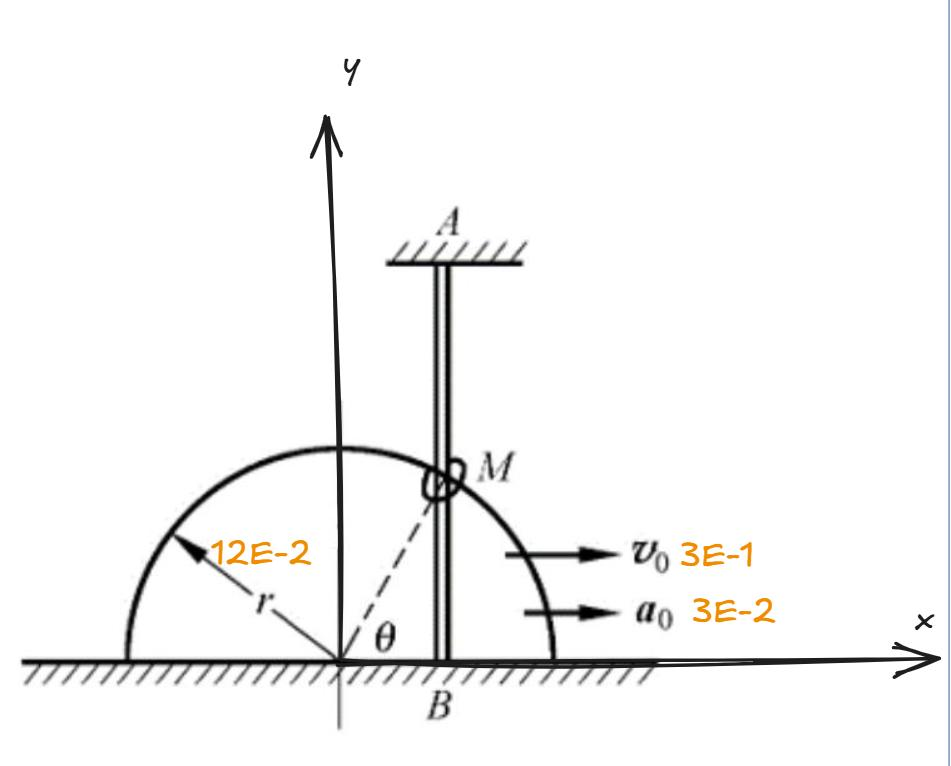

In [6]:
reset()


def t318():
    t, V_0, a_0, r, theta = symbols('t V_0 a_0 r theta')
    x = beautiful_compute(Function('x')(t), r * cos(theta) - V_0 * t - a_0 * t ** 2 / 2)
    y = beautiful_compute(Function('y')(t), sqrt(r ** 2 - x ** 2))
    beautiful_answer(diff(y, t))
    beautiful_answer(diff(y, t, 2))
    save_as_variable(t, 0)

    save_as_variable(r, 12E-2)
    save_as_variable(V_0, 3E-1)
    save_as_variable(a_0, 3E-2)
    save_as_variable(theta, pi / 3)
    beautiful_answer(diff(y, t))
    beautiful_answer(diff(y, t, 2))


t318()

$$x{\left(t \right)} = - V_{0} t - \frac{a_{0} t^{2}}{2} + r \cos{\left(\theta \right)}$$

$$y{\left(t \right)} = \sqrt{r^{2} - x^{2}{\left(t \right)}}$$

$$\frac{d}{d t} y{\left(t \right)} = \frac{\left(- V_{0} - a_{0} t\right) \left(2 V_{0} t + a_{0} t^{2} - 2 r \cos{\left(\theta \right)}\right)}{\sqrt{4 r^{2} - \left(2 V_{0} t + a_{0} t^{2} - 2 r \cos{\left(\theta \right)}\right)^{2}}}\tag{answer}$$

$$\frac{d^{2}}{d t^{2}} y{\left(t \right)} = \frac{- 2 \left(V_{0} + a_{0} t\right)^{2} \left(2 V_{0} t + a_{0} t^{2} - 2 r \cos{\left(\theta \right)}\right)^{2} - \left(4 r^{2} - \left(2 V_{0} t + a_{0} t^{2} - 2 r \cos{\left(\theta \right)}\right)^{2}\right) \left(a_{0} \left(2 V_{0} t + a_{0} t^{2} - 2 r \cos{\left(\theta \right)}\right) + 2 \left(V_{0} + a_{0} t\right)^{2}\right)}{\left(4 r^{2} - \left(2 V_{0} t + a_{0} t^{2} - 2 r \cos{\left(\theta \right)}\right)^{2}\right)^{\frac{3}{2}}}\tag{answer}$$

$$\frac{d}{d t} y{\left(t \right)} = 0.1 \sqrt{3}\tag{answer}$$

$$\frac{d^{2}}{d t^{2}} y{\left(t \right)} = - 0.656666666666667 \sqrt{3}\tag{answer}$$

# 3.19

In [10]:
reset()


def t319():
    l, R, omega_1, omega_2 = symbols('l R omega_1 omega_2', positive=True)
    t = symbols('t', positive=True)
    theta_1 = beautiful_compute(Function('theta_1')(t), omega_1 * t)
    theta_2 = beautiful_compute(Function('theta_2')(t), omega_2 * t)

    def transform(rot, tx, ty):
        return Matrix([
            [cos(rot), -sin(rot), tx],
            [sin(rot), cos(rot), ty],
            [0, 0, 1]
        ])

    T1 = transform(theta_1, 0, 0)
    beautiful_print(T1)
    T2 = transform(theta_2, l, 0)
    beautiful_print(T2)

    P = T1 * T2 * Matrix([
        R, 0, 1
    ])
    beautiful_print(P)
    beautiful_peek(lambda  e: diff(P, t, evaluate=e))
    beautiful_peek(lambda  e: diff(P, t, 2,evaluate=e))
    save_as_variable(t,0)
    beautiful_print(spf(diff(P, t)),"$", tag="answer")
    beautiful_print(spf(diff(P, t, 2)),"$", tag="answer")


t319()

$$\theta_{1}{\left(t \right)} = \omega_{1} t$$

$$\theta_{2}{\left(t \right)} = \omega_{2} t$$

$$\left[\begin{matrix}\cos{\left(\theta_{1}{\left(t \right)} \right)} & - \sin{\left(\theta_{1}{\left(t \right)} \right)} & 0\\\sin{\left(\theta_{1}{\left(t \right)} \right)} & \cos{\left(\theta_{1}{\left(t \right)} \right)} & 0\\0 & 0 & 1\end{matrix}\right]$$

$$\left[\begin{matrix}\cos{\left(\theta_{2}{\left(t \right)} \right)} & - \sin{\left(\theta_{2}{\left(t \right)} \right)} & l\\\sin{\left(\theta_{2}{\left(t \right)} \right)} & \cos{\left(\theta_{2}{\left(t \right)} \right)} & 0\\0 & 0 & 1\end{matrix}\right]$$

$$\left[\begin{matrix}R \left(- \sin{\left(\theta_{1}{\left(t \right)} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} + \cos{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)}\right) + l \cos{\left(\theta_{1}{\left(t \right)} \right)}\\R \left(\sin{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} + \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} \right)}\right) + l \sin{\left(\theta_{1}{\left(t \right)} \right)}\\1\end{matrix}\right]$$

$$\frac{\partial}{\partial t} \left[\begin{matrix}R \left(- \sin{\left(\theta_{1}{\left(t \right)} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} + \cos{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)}\right) + l \cos{\left(\theta_{1}{\left(t \right)} \right)}\\R \left(\sin{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} + \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} \right)}\right) + l \sin{\left(\theta_{1}{\left(t \right)} \right)}\\1\end{matrix}\right] = \left[\begin{matrix}- R \left(\omega_{1} + \omega_{2}\right) \sin{\left(t \left(\omega_{1} + \omega_{2}\right) \right)} - l \omega_{1} \sin{\left(\omega_{1} t \right)}\\R \left(\omega_{1} + \omega_{2}\right) \cos{\left(t \left(\omega_{1} + \omega_{2}\right) \right)} + l \omega_{1} \cos{\left(\omega_{1} t \right)}\\0\end{matrix}\right]$$

$$\frac{\partial^{2}}{\partial t^{2}} \left[\begin{matrix}R \left(- \sin{\left(\theta_{1}{\left(t \right)} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} + \cos{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)}\right) + l \cos{\left(\theta_{1}{\left(t \right)} \right)}\\R \left(\sin{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} + \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} \right)}\right) + l \sin{\left(\theta_{1}{\left(t \right)} \right)}\\1\end{matrix}\right] = \left[\begin{matrix}- R \omega_{1}^{2} \cos{\left(t \left(\omega_{1} + \omega_{2}\right) \right)} - 2 R \omega_{1} \omega_{2} \cos{\left(t \left(\omega_{1} + \omega_{2}\right) \right)} - R \omega_{2}^{2} \cos{\left(t \left(\omega_{1} + \omega_{2}\right) \right)} - l \omega_{1}^{2} \cos{\left(\omega_{1} t \right)}\\- R \left(\omega_{1}^{2} + 2 \omega_{1} \omega_{2} + \omega_{2}^{2}\right) \sin{\left(t \left(\omega_{1} + \omega_{2}\right) \right)} - l \omega_{1}^{2} \sin{\left(\omega_{1} t \right)}\\0\end{matrix}\right]$$

$$\left[\begin{matrix}0\\R \left(\omega_{1} + \omega_{2}\right) + l \omega_{1}\\0\end{matrix}\right]\tag{answer}$$

$$\left[\begin{matrix}- R \omega_{1}^{2} - 2 R \omega_{1} \omega_{2} - R \omega_{2}^{2} - l \omega_{1}^{2}\\0\\0\end{matrix}\right]\tag{answer}$$

# 3.34
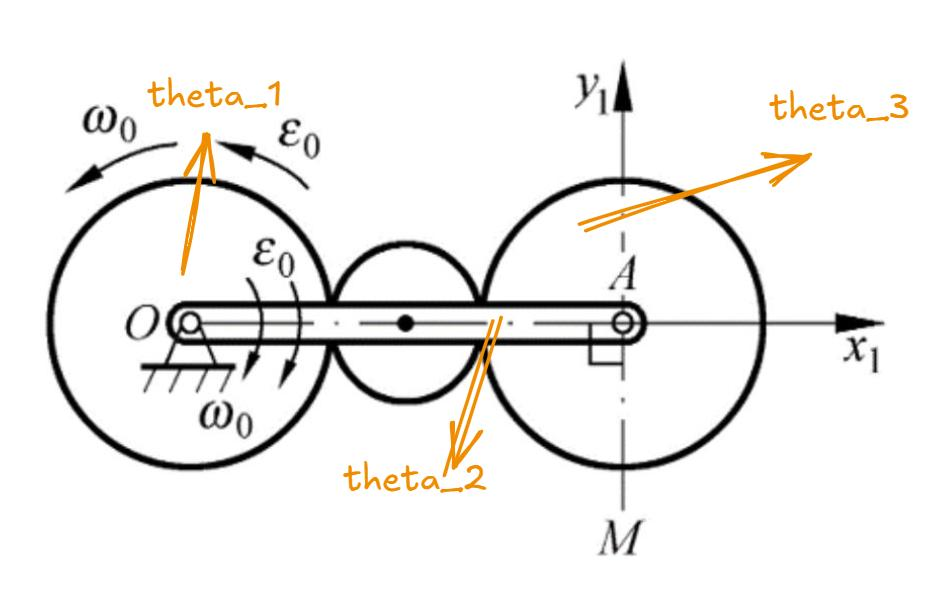

In [11]:
reset()


def t334():
    t, omega, epsilon, R = symbols('t omega epsilon R', positive=True)
    l = beautiful_compute('l', 3 * R)
    theta_1 = beautiful_compute(Function('theta_1')(t), omega * t + epsilon * t ** 2 / 2)
    theta_2 = beautiful_compute(Function('theta_2')(t), - theta_1)

    theta_3 = beautiful_compute('theta_3', theta_1 - theta_2,
                                "in the pole' world the 1st wheel rot as it, and the 3nd wheel is alike as they"
                                "have the same radius:$")

    def transform(rot, tx, ty):
        return Matrix([
            [cos(rot), -sin(rot), tx],
            [sin(rot), cos(rot), ty],
            [0, 0, 1]
        ])

    T1 = transform(theta_2, 0, 0)
    beautiful_print(T1)
    T2 = transform(theta_3, l, 0)
    beautiful_print(T2)

    T = T1 * T2
    P = T * Matrix([
        0, -R, 1
    ])
    beautiful_print(P)
    beautiful_peek(diff(P, t))
    beautiful_peek(diff(P, t, 2))
    save_as_variable(t,0)
    beautiful_print(spf(diff(P, t)),"$", tag="answer")
    beautiful_print(spf(diff(P, t, 2)),"$", tag="answer")


t334()

$$l = 3 R$$

$$\theta_{1}{\left(t \right)} = \frac{\epsilon t^{2}}{2} + \omega t$$

$$\theta_{2}{\left(t \right)} = - \theta_{1}{\left(t \right)}$$

in the pole' world the 1st wheel rot as it, and the 3nd wheel is alike as theyhave the same radius:$$\theta_{3} = \theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)}$$

$$\left[\begin{matrix}\cos{\left(\theta_{2}{\left(t \right)} \right)} & - \sin{\left(\theta_{2}{\left(t \right)} \right)} & 0\\\sin{\left(\theta_{2}{\left(t \right)} \right)} & \cos{\left(\theta_{2}{\left(t \right)} \right)} & 0\\0 & 0 & 1\end{matrix}\right]$$

$$\left[\begin{matrix}\cos{\left(\theta_{3} \right)} & - \sin{\left(\theta_{3} \right)} & l\\\sin{\left(\theta_{3} \right)} & \cos{\left(\theta_{3} \right)} & 0\\0 & 0 & 1\end{matrix}\right]$$

$$\left[\begin{matrix}- R \left(- \sin{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} - \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{3} \right)}\right) + l \cos{\left(\theta_{2}{\left(t \right)} \right)}\\- R \left(- \sin{\left(\theta_{3} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} + \cos{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)}\right) + l \sin{\left(\theta_{2}{\left(t \right)} \right)}\\1\end{matrix}\right]$$

$$\left[\begin{matrix}- R \left(\sin{\left(\theta_{3} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)} - \cos{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)}\right) - l \sin{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)}\\- R \left(- \sin{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)} - \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{3} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)}\right) + l \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)}\\0\end{matrix}\right] = \left[\begin{matrix}- R \left(\epsilon t + \omega\right) \left(3 \sin{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} + \cos{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)}\right)\\- R \left(\epsilon t + \omega\right) \left(\sin{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} + 3 \cos{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)}\right)\\0\end{matrix}\right]$$

$$\left[\begin{matrix}- (R \left(\sin{\left(\theta_{3} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)} + \sin{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2} + \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{3} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2} - \cos{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)}\right) + l \sin{\left(\theta_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)} + l \cos{\left(\theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2})\\R \left(- \sin{\left(\theta_{3} \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2} + \sin{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)} + \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{3} \right)} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)} + \cos{\left(\theta_{3} \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2}\right) - l \sin{\left(\theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2} + l \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)}\\0\end{matrix}\right] = \left[\begin{matrix}- R \left(3 \epsilon \sin{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} + \epsilon \cos{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} + \left(\epsilon t + \omega\right)^{2} \sin{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} + 3 \left(\epsilon t + \omega\right)^{2} \cos{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)}\right)\\- R \left(\epsilon \sin{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} + 3 \epsilon \cos{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} - 3 \left(\epsilon t + \omega\right)^{2} \sin{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)} - \left(\epsilon t + \omega\right)^{2} \cos{\left(t \left(\frac{\epsilon t}{2} + \omega\right) \right)}\right)\\0\end{matrix}\right]$$

$$\left[\begin{matrix}- R \omega\\- 3 R \omega\\0\end{matrix}\right]\tag{answer}$$

$$\left[\begin{matrix}- R \left(\epsilon + 3 \omega^{2}\right)\\R \left(- 3 \epsilon + \omega^{2}\right)\\0\end{matrix}\right]\tag{answer}$$